In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
%matplotlib inline
import scipy.misc
from PIL import Image
import scipy.io as scio
import os
from pylab import * # for showing
from termios import VMIN
import time

caffe_root = '/root/Workspace/caffe-addlayer/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

In [90]:
data_root = '/root/Workspace/hed-master/data/HED-BSDS/'
with open(data_root+'test.lst') as f:
    test_lst = f.readlines()    
test_lst = [data_root + x.strip() for x in test_lst]

im_lst = []
# len(test_lst)
for i in range(0, len(test_lst)):
    im = Image.open(test_lst[i])
    in_ = np.array(im, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    im_lst.append(in_)
    
#Visualization
def plot_single_scale(scale_lst, size):
    pylab.rcParams['figure.figsize'] = size, size/2
    
    plt.figure()
    for i in range(0, len(scale_lst)):
        s=plt.subplot(1,5,i+1)
        plt.imshow(1-scale_lst[i], cmap = cm.Greys_r)
        #plt.imshow(1-scale_lst[i])
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
    plt.tight_layout()


In [91]:
idx = 1

in_ = im_lst[idx]
in_ = in_.transpose((2,0,1))
#remove the following two lines if testing with cpu
caffe.set_mode_gpu()
caffe.set_device(1)

In [92]:
# load net
model_root = '/root/Workspace/caffe-addlayer/examples/SRN/'
net = caffe.Net(model_root+'deploy.prototxt', model_root+'san_iter_18000.caffemodel', caffe.TEST)

In [93]:
# hed_symmetry_final_my
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_

In [94]:
# run net and take argmax for prediction
net.forward()

{'sigmoid-dsn1': array([[[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
             8.62603391e-12,   4.09348445e-16,   1.05972701e-20],
          [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
             3.44161574e-11,   1.14207072e-15,   2.04745183e-20],
          [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
             9.23724708e-11,   2.48313786e-15,   3.21365646e-20],
          ..., 
          [  4.53479555e-37,   4.09720389e-38,   0.00000000e+00, ...,
             7.96225808e-19,   9.28041782e-20,   3.42458630e-21],
          [  6.47738534e-37,   8.26768056e-38,   4.66519584e-39, ...,
             1.04575643e-19,   9.39288789e-21,   3.37167153e-22],
          [  5.86040820e-37,   9.84188748e-38,   1.14287661e-38, ...,
             4.09830270e-21,   3.72864232e-22,   1.37769445e-23]]]], dtype=float32),
 'sigmoid-dsn2': array([[[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
             1.60336219e-12,   3.78807725e-17, 

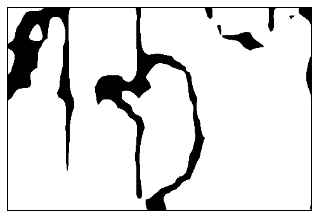

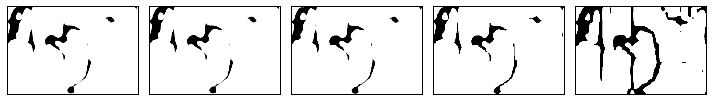

In [95]:
out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

scale_lst = [fuse]
plot_single_scale(scale_lst, 22)
scale_lst = [out1, out2, out3, out4, out5]
plot_single_scale(scale_lst, 10)
show()

In [96]:
startLoc = len('/root/Workspace/hed-master/data/HED-BSDS/test/')

start_time = time.time()
for iidx in range(0, len(test_lst)):
    in_ = im_lst[iidx]
    in_ = in_.transpose((2,0,1))
    net.blobs['data'].reshape(1, *in_.shape)
    net.blobs['data'].data[...] = in_
    net.forward()
    fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]
    
    fileName = test_lst[iidx]
    fileName = fileName[startLoc:(len(fileName)-4)]
    fileName = './BSDS500/' + fileName + '.mat'
    scio.savemat(fileName, {'edge':fuse})
    
diff_time = time.time() - start_time
print 'Detection took {:.3f}s per image'.format(diff_time/len(test_lst))

Detection took 0.101s per image
